# Evaluations DGP Waves

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import pickle

from addict import Dict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

from scipy.integrate import odeint
import cloudpickle

from mmfm.data import dgp_beijing_data
from mmfm.trajectory import sample_trajectory
from mmfm.evaluation import compute_metric_set
from mmfm.models import VectorFieldModel, MultiVectorFieldModel, MultiVectorFieldModelTCFM
from mmfm.utils_eval import (
    load_all_fm_models,
    process_all_fm_models,
    # predict_on_testset_fsi,
)
from mmfm.utils import color_picker, create_plot_grid, COLORMAP10, ThickerLine2D, COLORMAP12

# # Plotting settings
# params = {
#     "axes.labelsize": 18,
#     "axes.titlesize": 22,
#     "xtick.labelsize": 18,
#     "ytick.labelsize": 18,
#     "legend.fontsize": 18,
#     "legend.title_fontsize": 18,
#     "figure.titlesize": 30,
# }
# plt.rcParams.update(params)
# plt.style.use(["science", "no-latex"])


In [3]:
PROD = True
minimum_seeds = 1
dimension = 1
batch_size = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_name_fsi = "/data/m015k/results/dgp_weather/results_fsi"
verbose = False

# Data
DGP = "a"
label_list = list(np.linspace(1, 12, 12, endpoint=True))

ns_per_t_and_c = 50
coupling = "cot"
train_test_split = 0.5
embedding_type = "free"
classifier_free = False

n_top_models = 1
n_top_seeds = 1
model_string = "dgp_weather"
average_out_seed = False
select_by = "mean_diff_l1"

### Load all models

In [4]:
def load_all_models(prod, dgp, load_parquet=True, coupling=None, embedding_type=None, filter_values=None):
    if load_parquet & (Path("data") / f"df_gt_{dgp}.parquet").exists():
        # This file contains all model train and validation results in a tidy format
        # i.e., each row corresponds to a single model run (model, seed, guidance, etc.)
        df = pd.read_parquet(Path("data") / f"df_gt_{dgp}.parquet")
        # Try to convert each value in column flow_variance to float if possible, otherwise leave value as string
        try:
            df["flow_variance"] = df["flow_variance"].astype(float)
        except ValueError:
            pass
        with open(Path("data") / f"grouping_columns_{dgp}.pkl", "rb") as f:
            grouping_columns = pickle.load(f)
        with open(Path("data") / f"performance_columns_{dgp}.pkl", "rb") as f:
            performance_columns = pickle.load(f)
    else:
        df, grouping_columns, performance_columns = load_all_fm_models(
            path="/data/m015k/results/dgp_weather/results_mmfm",
            production=prod,  # If prod is false, only load a small subset of data
            dgp=DGP,
            coupling=coupling,
            embedding_type=embedding_type,
            filter_values=filter_values,
        )

        # Filter for only validation results
        df.loc[:, "train"] = df["train"].astype(bool)
        df = df.loc[~df["train"]]

        # Save everything
        # Convert
        df["flow_variance"] = df["flow_variance"].astype(str)
        print(f"Saving data with shape {df.shape}")
        df.to_parquet(Path("data") / f"df_gt_{dgp}.parquet")
        # Try to convert each value in column flow_variance to float if possible, otherwise leave value as string
        try:
            df["flow_variance"] = df["flow_variance"].astype(float)
        except ValueError:
            pass

        with open(Path("data") / f"grouping_columns_{dgp}.pkl", "wb") as f:
            pickle.dump(grouping_columns, f)
        with open(Path("data") / f"performance_columns_{dgp}.pkl", "wb") as f:
            pickle.dump(performance_columns, f)

    return df, grouping_columns, performance_columns

### Preprocess all MMFM models

In [5]:
df, grouping_columns, performance_columns = load_all_models(
    PROD, DGP, load_parquet=False, coupling=coupling, embedding_type=embedding_type, filter_values="mmfm"
)
model_type = "mmfm"

100%|██████████| 2506/2506 [00:20<00:00, 124.17it/s]


Saving data with shape (2920320, 32)


In [6]:
print(f"Data before filtering: {df.shape}")

df = df.loc[
    (df["ns_per_t_and_c"] == ns_per_t_and_c)
    & (df["coupling"] == coupling)
    & (df["train_test_split"] == train_test_split)
    & (df["embedding_type"] == embedding_type)
    & (df["model_type"] == model_type)
    & (df["p_unconditional"] > 0.0)
]
if not classifier_free:
    df = df.loc[~df["classifier_free"]]

# Filter for only validation results
df.loc[:, "train"] = df["train"].astype(bool)
df = df.loc[~df["train"]]

df = df.loc[(df["interpolation"] == "cubic")]

print(f"Data after 1st filtering: {df.shape}")

df, grouping_columns, performance_columns = process_all_fm_models(
    df,
    grouping_columns,
    performance_columns,
    plot=False,
    verbose=True,
    minimum_seeds=minimum_seeds,
    data_cols=[
        "ns_per_t_and_c",
        "coupling",
        "dgp",
        "interpolation",
        "guidance",
        "embedding_type",
        "classifier_free",
    ],
)

print(f"Data after 2nd filtering: {df.shape}")

Data before filtering: (2920320, 32)
Data after 1st filtering: (1269528, 32)
Number of models before adjusting for seeds: 1269528
Number of models after adjusting for seeds:  1269528

Dropping column seed with only one unique value: 0
Dropping column p_unconditional with only one unique value: 0.1
- Skipping column ns_per_t_and_c
- Skipping column embedding_type
Dropping column normalization with only one unique value: None
Dropping column n_classes with only one unique value: 12
- Skipping column interpolation
Dropping column conditional_model with only one unique value: True
- Skipping column classifier_free
- Skipping column coupling
Dropping column train_test_split with only one unique value: 0.5
- Skipping column dgp
Dropping column conditional_bias with only one unique value: False
Dropping column model_type with only one unique value: mmfm
Dropping column matching with only one unique value: emd
- Skipping column guidance
Dropping column train with only one unique value: False
D

### Find best model on Validation Set

In [7]:
def get_model_battery_of_best_models_wc(
    df, select_by, n_top_seeds, model_string, dgp, average_out_seed=True, verbose=False, selector="mean", model=None
):
    """Find best model according to a given metric and return the model battery of the best model.

    We use either use mean or max statistics on the holdout validation data to select the best model.
    """

    def weighted_avg(group_df, whole_df, values, weights):
        v = whole_df.loc[group_df.index, values]
        w = whole_df.loc[group_df.index, weights]
        return (v * w).sum() / w.sum()

    def weighted_max(group_df, whole_df, values, weights):
        v = whole_df.loc[group_df.index, values]
        w = whole_df.loc[group_df.index, weights]
        return (v * w).max()

    if average_out_seed:
        grouping = [x for x in grouping_columns if x not in ["marginal", "time", "seed"]]
    else:
        grouping = [x for x in grouping_columns if x not in ["marginal", "time"]]

    df_agg = (
        (
            df.drop(columns=["marginal", "time"])
            .groupby(grouping)
            .agg(
                scoring_mean=(select_by, lambda x: weighted_avg(x, df, select_by, "weight")),
                scoring_max=(select_by, lambda x: weighted_max(x, df, select_by, "weight")),
                filename_first=("filename", "first"),
            )
        )
        .reset_index()
        .rename(
            columns={
                "scoring_mean": f"{select_by}_mean",
                "scoring_max": f"{select_by}_max",
            }
        )
    )

    # Enumerate all filenames
    map_filename_to_id = {filename: idx for idx, filename in enumerate(df_agg["filename_first"].unique())}
    df_agg["id"] = df_agg["filename_first"].map(map_filename_to_id)

    # Average out everything except for id, c, guidance
    df_agg2 = df_agg.groupby(["id", "c", "guidance"])[f"{select_by}_{selector}"].mean().reset_index()

    # For each combination of c and id, find the guidance value where the mean_diff_l2_mean is lowest
    guidances = df_agg2.loc[df_agg2.groupby(["id", "c"])[f"{select_by}_{selector}"].idxmin()]

    # Compute best score across conditions for each model
    guidances_scores = (
        guidances.groupby(["id"])[f"{select_by}_{selector}"]
        .mean()
        .reset_index()
        .sort_values(by=f"{select_by}_{selector}", ascending=True)
    )

    best_model_id = guidances_scores["id"].iloc[0]
    best_model = [x for x in df_agg["filename_first"].unique() if map_filename_to_id[x] == best_model_id][0]

    df_agg_c = df.loc[df["filename"] == best_model, :]

    model_battery = Dict()
    model_guidances = Dict()
    model_states = Dict()
    gudiance_best_model = guidances[guidances.id == best_model_id]

    for _, c in enumerate(df_agg_c["c"].unique()):
        model_guidances[c] = gudiance_best_model.loc[gudiance_best_model["c"] == c, "guidance"].iloc[0]

        # Load the model from its filename and all its seed-variations
        model_path = best_model
        model_path = model_path.replace("df_results.csv", "model.pt")

        # print(f"Loading model from {model_path}")

        for seed in range(n_top_seeds):
            # Replace "dgp2_{seed}" with "dgp2_x" in the path
            current_seed = model_path.split("_")[5]
            model_path = model_path.replace(f"{model_string}_{dgp}_{current_seed}", f"{model_string}_{dgp}_{seed}")
            filename = model_path.split("/")[-2]

            try:
                state = torch.load(model_path, weights_only=True)
                if verbose:
                    print(f"✓ {filename}")

            except FileNotFoundError:
                if verbose:
                    print(f"✗ {filename}")
                continue

            if model is None:
                mmfm_model = VectorFieldModel(
                    data_dim=state["dimension"] if "dimension" in state else state["use_pca"],
                    x_latent_dim=state["x_latent_dim"],
                    time_embed_dim=state["time_embed_dim"],
                    cond_embed_dim=state["cond_embed_dim"],
                    conditional_model=state["conditional_model"],
                    embedding_type=state["embedding_type"],
                    n_classes=state["n_classes"],
                    label_list=label_list,
                    normalization=state["normalization"],
                    activation=state["activation"],
                    affine_transform=state["affine_transform"],
                    sum_time_embed=state["sum_time_embed"],
                    sum_cond_embed=state["sum_cond_embed"],
                    max_norm_embedding=state["max_norm_embedding"],
                    num_out_layers=state["num_out_layers"],
                    spectral_norm=state["spectral_norm"],
                    dropout=state["dropout"],
                    conditional_bias=state["conditional_bias"],
                    keep_constants=state["keep_constants"],
                ).to(device)
            elif model == "totcfm":
                mmfm_model = MultiVectorFieldModelTCFM(
                    model_list=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                    data_dim=state["dimension"],
                    x_latent_dim=state["x_latent_dim"],
                    time_embed_dim=state["time_embed_dim"],
                    cond_embed_dim=state["cond_embed_dim"],
                    conditional_model=state["conditional_model"],
                    embedding_type=state["embedding_type"],
                    n_classes=state["n_classes"],
                    label_list=label_list,
                    normalization=state["normalization"],
                    activation=state["activation"],
                    affine_transform=state["affine_transform"],
                    sum_time_embed=state["sum_time_embed"],
                    sum_cond_embed=state["sum_cond_embed"],
                    max_norm_embedding=state["max_norm_embedding"],
                    num_out_layers=state["num_out_layers"],
                    spectral_norm=state["spectral_norm"],
                    dropout=state["dropout"],
                    conditional_bias=state["conditional_bias"],
                    keep_constants=state["keep_constants"],
                ).to(device)
            elif model == "tcotcfm":
                mmfm_model = MultiVectorFieldModel(
                    model_list={
                        1: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        1.5: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        2: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        2.5: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        3: [0, 0.1, 0.5, 0.9, 1],
                        3.5: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        4: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        4.5: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        5: [0, 0.3, 0.5, 0.7, 1],
                        5.5: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        6: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                        6.5: [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                    },
                    data_dim=state["dimension"],
                    x_latent_dim=state["x_latent_dim"],
                    time_embed_dim=state["time_embed_dim"],
                    cond_embed_dim=state["cond_embed_dim"],
                    conditional_model=state["conditional_model"],
                    embedding_type=state["embedding_type"],
                    n_classes=state["n_classes"],
                    label_list=label_list,
                    normalization=state["normalization"],
                    activation=state["activation"],
                    affine_transform=state["affine_transform"],
                    sum_time_embed=state["sum_time_embed"],
                    sum_cond_embed=state["sum_cond_embed"],
                    max_norm_embedding=state["max_norm_embedding"],
                    num_out_layers=state["num_out_layers"],
                    spectral_norm=state["spectral_norm"],
                    dropout=state["dropout"],
                    conditional_bias=state["conditional_bias"],
                    keep_constants=state["keep_constants"],
                ).to(device)

            mmfm_model.load_state_dict(state["state_dict"], strict=True)
            model_battery[seed] = mmfm_model
            model_states[seed] = state

    # Set guidance for all other c to 0
    missing_c = set(df_agg_c["c"].unique()) - set(df_agg["c"].unique())
    for c in missing_c:
        model_guidances[c] = 0

    return model_battery, model_guidances, model_states

In [8]:
def plot_models_wc(
    trajectory,
    ncols,
    s,
    coupling,
    batch_size,
    ns_per_t_and_c,
    dgp,
    seed=0,
    save=False,
    suffix=None,
    already_subset=False
):
    """Plot the trajectories of the best models for each condition c in a grid."""
    # We only load the train data, because we want to plot it in the background
    from mmfm.data import dgp_beijing_data
    # _, X_train, y_train, t_train, _, _, _, n_classes, _ = dgp_beijing_data(
    #     coupling, batch_size, ns_per_t_and_c, DGP, return_data="train-valid"
    # )
    # t = t_train
    X_train, y_train, t_train, n_classes, timepoints, label_list = dgp_beijing_data(
        coupling, batch_size, ns_per_t_and_c, DGP, return_data="test"
    )
    t = t_train

    fig, ax, ncols, _ = create_plot_grid(n_classes, ncols=ncols)

    df = pd.DataFrame(X_train.reshape(-1, 1)).assign(target=y_train.reshape(-1, 1), time=t_train.reshape(-1, 1))
    df.columns = ["y", "target", "x"]

    color_classes = [int(x) for x in range(len([x for x in np.unique(y_train) if np.isfinite(x)]))]
    colors = color_picker(color_classes)
    non_nan_targets = [x for x in np.unique(y_train) if np.isfinite(x)]

    # Plot backgrounds
    s = 2
    for k, c in enumerate(non_nan_targets):
        axidx = ax[k // ncols, k % ncols]
        sns.scatterplot(data=df, x="x", y="y", hue="target", ax=axidx, legend=False, alpha=0.05, palette=colors, s=s)
        sns.scatterplot(data=df[df["target"] == c], x="x", y="y", ax=axidx, color=colors[k], s=30)
        sns.lineplot(data=df[df["target"] == c], x="x", y="y", ax=axidx, color=colors[k])
        axidx.set_title(f"Condition c={c}")

    # # Plot ground truth trajectories
    # already_subset = False
    # for k, c in enumerate(non_nan_targets):
    #     if not already_subset:
    #         idx_plot = np.where(y_train[:, 0] == c)[0][:2]
    #     else:
    #         idx_plot = [0, 1]
    #     for n in idx_plot:
    #         y0 = trajectory[c][seed][0, n]#, y_train[n, 0]
    #         t = np.linspace(0, 1, 101)
    #         sol = odeint(u, y0, t, args=(c,))
    #         ax[k // ncols, k % ncols].plot(sol[:, 0], sol[:, 1], color="blue", alpha=0.2, lw=7.5)

    # Plot predicted marginals
    # Plot ground truth trajectories
    for k, c in enumerate(non_nan_targets):
        if not already_subset:
            idx_plot = np.where(y_train[:, 0] == c)[0][:2]
        else:
            idx_plot = [0, 1]

        for n in idx_plot:
            for i in range(len(trj[c][seed]) - 1):
                ax[k // ncols, k % ncols].plot(
                    [i/100, (i+1)/100],
                    [trajectory[c][seed][i, n, 0], trajectory[c][seed][i + 1, n, 0]],
                    color="black",
                    lw=2,
                )

    plt.tight_layout()
    if save:
        fn = f"/data/m015k/code/MMFM/figures_paper/trajectory_wave_{seed}_35.png"
        if suffix is not None:
            fn = fn.replace(".png", f"_{suffix}.png")
        plt.savefig(fn)
    plt.show()

In [9]:
# Add weight column to lay focus on conditional generalization
df_cubic = df.copy()
df_cubic.loc[:, "weight"] = 1

print(df_cubic.shape)

# this is our extra validation timepoint
# Note, that for a fair comparison we provide this sample as training data to FSI
add_time_cond = None  # (7, 0.15)

# Create a new column 
timepoint_to_integer = {v: k for k,v in enumerate(sorted(df_cubic["time"].unique()))}
integer_to_timepoint = {k: v for k,v in enumerate(sorted(df_cubic["time"].unique()))}
df["timestep"] = df["time"].map(timepoint_to_integer)

# # Convert to timepoints
# timepoints = [0, 6, 11, 13, 19, 25] #[0, 2, 4, 6, 7, 11, 12, 14, 16, 18, 19, 23, 25]
# timepoints = [float(integer_to_timepoint[x]) for x in timepoints]
# timepoints

(1269528, 22)


In [10]:
# Filtering for target validation time and c
if DGP == "a":
    # (4, 23), (7, 9), (10, 8)
    df_cubic_valid = df_cubic.loc[
        ((df_cubic["c"] == 4) & (df_cubic["time"].isin([0.04 * x for x in [0, 5, 9, 10, 17, 20, 25]])))
        | ((df_cubic["c"] == 7) & (df_cubic["time"].isin([0.04 * x for x in [0, 3, 11, 13, 17, 20, 25]])))
        | ((df_cubic["c"] == 10) & (df_cubic["time"].isin([0.04 * x for x in [0, 4, 11, 13, 17, 23, 25]])))
        | ((df_cubic["c"] != 4) & (df_cubic["c"] != 7) & (df_cubic["c"] != 10) & (df_cubic["time"].isin([0.04 * x for x in [0, 2, 4, 6, 7, 11, 12, 14, 16, 18, 19, 23, 25]])))
    ]
    # df_cubic_valid["weight"] = 0.0000001
    # # df_cubic_valid.loc[(df_cubic_valid["c"] == 4) & (df_cubic_valid["time"].isin([0.04  * 23])), "weight"] = 1
    # df_cubic_valid.loc[(df_cubic_valid["c"] == 7) & (df_cubic_valid["time"].isin([0.04  * 11, 0.04*23])), "weight"] = 1
    # # df_cubic_valid.loc[(df_cubic_valid["c"] == 10) & (df_cubic_valid["time"].isin([0.04  * 8])), "weight"] = 1
if DGP == "b":
    df_cubic_valid = df_cubic.loc[
        ((df_cubic["c"] == 4) & (df_cubic["time"].isin([0.0, 0.24, 0.44, 0.52, 0.76, 1.0])))
        | ((df_cubic["c"] == 7) & (df_cubic["time"].isin([0.0, 0.24, 0.44, 0.52, 0.76, 1.0])))
        | ((df_cubic["c"] == 10) & (df_cubic["time"].isin([0.0, 0.24, 0.44, 0.52, 0.76, 1.0])))
        | ((df_cubic["c"] != 4) & (df_cubic["c"] != 7) & (df_cubic["c"] != 10) & (df_cubic["time"].isin([0.0, 0.24, 0.44, 0.52, 0.76, 1.0])))
    ]
    df_cubic_valid["weight"] = 1

In [11]:
# df, select_by, n_top_seeds, model_string, dgp, average_out_seed=True, verbose=False, selector="mean", model=None
df = df_cubic_valid
dgp = DGP
average_out_seed=True
selector="mean"

def weighted_avg(group_df, whole_df, values, weights):
    v = whole_df.loc[group_df.index, values]
    w = whole_df.loc[group_df.index, weights]
    return (v * w).sum() / w.sum()

def weighted_max(group_df, whole_df, values, weights):
    v = whole_df.loc[group_df.index, values]
    w = whole_df.loc[group_df.index, weights]
    return (v * w).max()

if average_out_seed:
    grouping = [x for x in grouping_columns if x not in ["marginal", "time", "seed"]]
else:
    grouping = [x for x in grouping_columns if x not in ["marginal", "time"]]

df_agg = (
    (
        df.drop(columns=["marginal", "time"])
        .groupby(grouping)
        .agg(
            scoring_mean=(select_by, lambda x: weighted_avg(x, df, select_by, "weight")),
            scoring_max=(select_by, lambda x: weighted_max(x, df, select_by, "weight")),
            filename_first=("filename", "first"),
        )
    )
    .reset_index()
    .rename(
        columns={
            "scoring_mean": f"{select_by}_mean",
            "scoring_max": f"{select_by}_max",
        }
    )
)
df_agg

,lr,flow_variance,ns_per_t_and_c,x_latent_dim,time_embed_dim,cond_embed_dim,embedding_type,interpolation,classifier_free,coupling,dgp,c,guidance,mean_diff_l1_mean,mean_diff_l1_max,filename_first
0,0.001,0.001,50,8,8,8,free,cubic,False,cot,a,1.0,0.0,25.386661,69.485886,/data/m015k/results/dgp_weather/results_mmfm/d...
1,0.001,0.001,50,8,8,8,free,cubic,False,cot,a,1.0,0.1,25.384406,69.491066,/data/m015k/results/dgp_weather/results_mmfm/d...
2,0.001,0.001,50,8,8,8,free,cubic,False,cot,a,1.0,0.2,25.381600,69.497030,/data/m015k/results/dgp_weather/results_mmfm/d...
3,0.001,0.001,50,8,8,8,free,cubic,False,cot,a,1.0,0.3,25.379059,69.503890,/data/m015k/results/dgp_weather/results_mmfm/d...
4,0.001,0.001,50,8,8,8,free,cubic,False,cot,a,1.0,0.4,25.376692,69.508835,/data/m015k/results/dgp_weather/results_mmfm/d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48823,0.020,1.000,50,16,16,8,free,cubic,False,cot,a,12.0,0.9,9.959945,34.347267,/data/m015k/results/dgp_weather/results_mmfm/d...
48824,0.020,1.000,50,16,16,8,free,cubic,False,cot,a,12.0,1.0,9.749262,33.784576,/data/m015k/results/dgp_weather/results_mmfm/d...
48825,0.020,1.000,50,16,16,8,free,cubic,False,cot,a,12.0,1.5,8.603785,30.248024,/data/m015k/results/dgp_weather/results_mmfm/d...
48826,0.020,1.000,50,16,16,8,free,cubic,False,cot,a,12.0,2.0,8.069992,25.621384,/data/m015k/results/dgp_weather/results_mmfm/d...


In [12]:
# Enumerate all filenames
map_filename_to_id = {filename: idx for idx, filename in enumerate(df_agg["filename_first"].unique())}
df_agg["id"] = df_agg["filename_first"].map(map_filename_to_id)

# Average out everything except for id, c, guidance
df_agg2 = df_agg.groupby(["id", "c", "guidance"])[f"{select_by}_{selector}"].mean().reset_index()

# For each combination of c and id, find the guidance value where the mean_diff_l2_mean is lowest
guidances = df_agg2.loc[df_agg2.groupby(["id", "c"])[f"{select_by}_{selector}"].idxmin()]

# Compute best score across conditions for each model
guidances_scores = (
    guidances.groupby(["id"])[f"{select_by}_{selector}"]
    .mean()
    .reset_index()
    .sort_values(by=f"{select_by}_{selector}", ascending=True)
)

best_model_id = guidances_scores["id"].iloc[0]
best_model = [x for x in df_agg["filename_first"].unique() if map_filename_to_id[x] == best_model_id][0]

df_agg_c = df.loc[df["filename"] == best_model, :]

model_battery = Dict()
model_guidances = Dict()
model_states = Dict()
gudiance_best_model = guidances[guidances.id == best_model_id]

In [13]:
gudiance_best_model

,id,c,guidance,mean_diff_l1_mean
40998,244,1.0,0.6,4.743488
41016,244,2.0,1.0,3.599838
41032,244,3.0,2.0,3.148682
41037,244,4.0,0.3,12.071893
41055,244,5.0,0.7,6.284622
41071,244,6.0,0.9,2.545062
41078,244,7.0,0.2,9.868636
41093,244,8.0,0.3,5.616643
41104,244,9.0,0.0,4.833367
41118,244,10.0,0.0,7.988736


In [14]:
model_battery, model_guidances, model_states = get_model_battery_of_best_models_wc(
    df_cubic_valid, select_by, n_top_seeds, model_string, DGP, average_out_seed=True, selector="mean"
)

X_test, y_test, t_test, n_classes, timepoints, all_classes = dgp_beijing_data(
    coupling, batch_size, ns_per_t_and_c, dgp=DGP, return_data="test"
)

In [15]:
from tqdm import tqdm

results_mmfm = Dict()
trajectories_test_mmfm = Dict()

for seed, model in tqdm(model_battery.items()):
    results = []
    for idx, c in enumerate(label_list):
        trajectories_test_mmfm[c][seed] = sample_trajectory(
            model,
            X=X_test[:, 0],
            y=y_test[:, 0],
            device=device,
            guidance=model_guidances[c],  # if model_guidances.get(c) else 1,
            conditional_model=model_states[seed]["conditional_model"],
            rtol=1e-7,
            atol=1e-9,
            steps=101,
            method="rk4",
        )

        trajectory = np.swapaxes(trajectories_test_mmfm[c][seed], 0, 1)
        trajectory = trajectory[
            np.arange(trajectory.shape[0])[:, None], (t_test * (trajectory.shape[1] - 1)).astype(int)
        ]

        for marginal in range(trajectory.shape[1]):
            target = X_test[:, marginal][y_test[:, marginal] == c]
            transport = trajectory[:, marginal][y_test[:, 0] == c]
            mmd, mmd_median, wasserstein, mean_diff_l1, mean_diff_l2, kl_div = compute_metric_set(target, transport)

            results.append(
                {
                    "marginal": marginal,
                    "c": c,
                    "mmd": mmd,
                    "mmd_median": mmd_median,
                    "wasserstein": wasserstein,
                    "guidance": model_guidances[c],
                    "train": False,
                    "time": t_test[0, marginal],
                    "mean_diff_l1": mean_diff_l1,
                    "mean_diff_l2": mean_diff_l2,
                    "kl_div": kl_div,
                    "seed": seed,
                }
            )

    results_mmfm[seed] = pd.DataFrame(results)

df_cubic_results_mmfm = pd.concat([results_mmfm[seed] for seed in results_mmfm], axis=0)
df_cubic_results_mmfm["model"] = "COT-MMFM"

100%|██████████| 1/1 [03:31<00:00, 211.44s/it]


for seed in range(3):
    try:
        plot_models_wc(
            trajectories_test_mmfm,
            6,
            20,
            coupling,
            batch_size,
            ns_per_t_and_c,
            DGP,
            seed,
            save=True,
        )
    except:
        pass

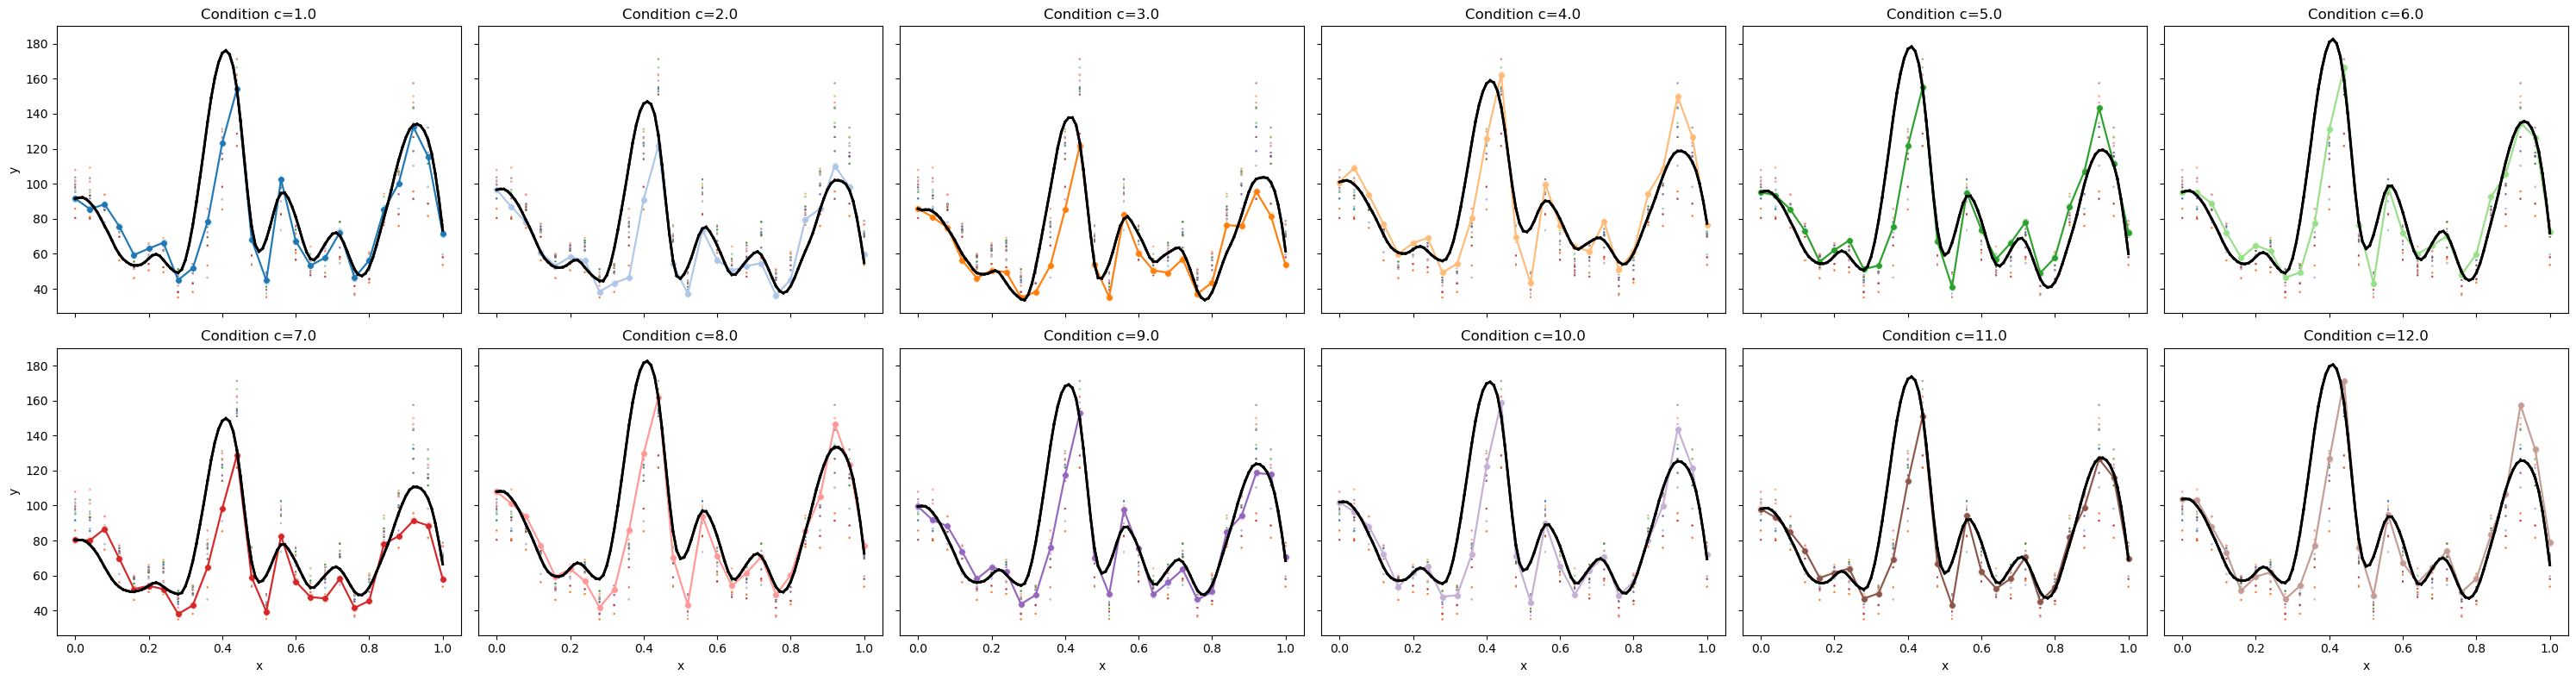

In [16]:
# Average conditional trajectories for each condition
trj = {
    c: np.mean([trajectories_test_mmfm[c][seed] for seed in trajectories_test_mmfm[c].keys()], axis=0)
    for c in label_list
}
for c in trj.keys():
    trj[c] = {0: trj[c]}

plot_models_wc(
    trj, 6, 20, coupling, batch_size, ns_per_t_and_c, DGP, 0, save=False, suffix="avg", already_subset=False
)

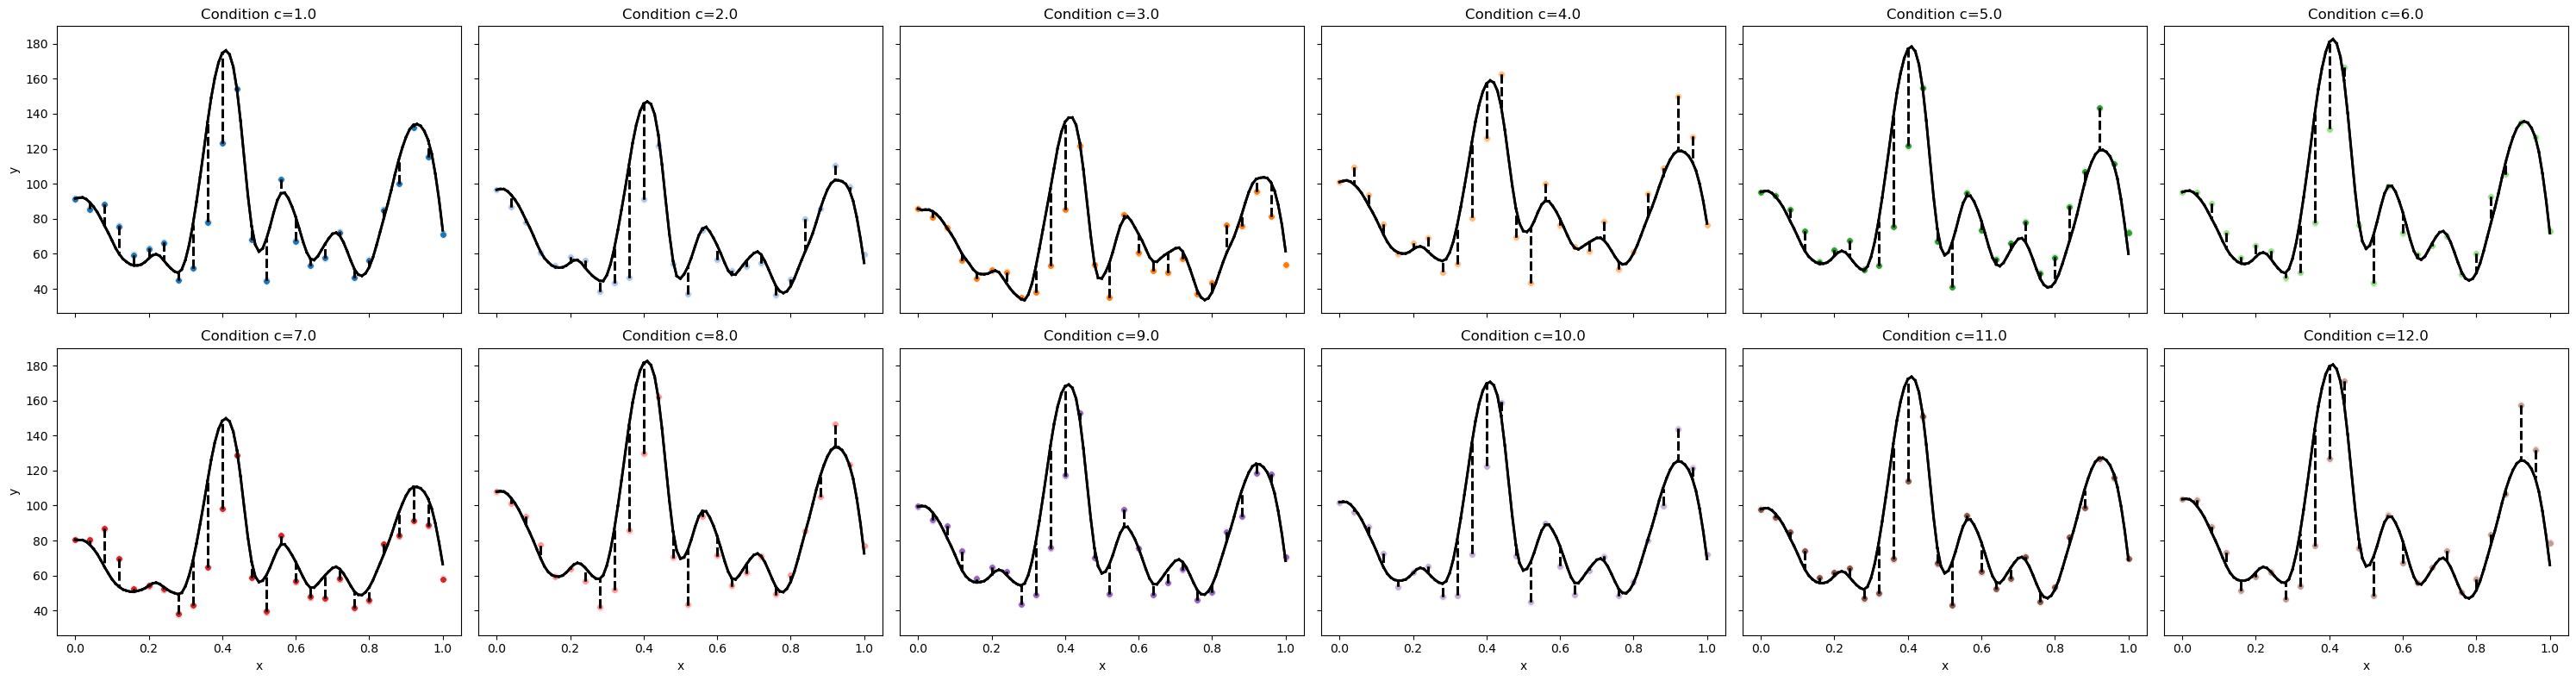

In [17]:
def plot_models_wc2(
    trajectory,
    ncols,
    s,
    coupling,
    batch_size,
    ns_per_t_and_c,
    dgp,
    seed=0,
    save=False,
    suffix=None,
    already_subset=False
):
    """Plot the trajectories of the best models for each condition c in a grid."""
    # We only load the train data, because we want to plot it in the background
    from mmfm.data import dgp_beijing_data
    X_train, y_train, t_train, n_classes, timepoints, label_list = dgp_beijing_data(
        coupling, batch_size, ns_per_t_and_c, DGP, return_data="test"
    )
    t = t_train

    fig, ax, ncols, _ = create_plot_grid(n_classes, ncols=ncols)

    df = pd.DataFrame(X_train.reshape(-1, 1)).assign(target=y_train.reshape(-1, 1), time=t_train.reshape(-1, 1))
    df.columns = ["y", "target", "x"]

    color_classes = [int(x) for x in range(len([x for x in np.unique(y_train) if np.isfinite(x)]))]
    colors = color_picker(color_classes)
    non_nan_targets = [x for x in np.unique(y_train) if np.isfinite(x)]

    # Plot backgrounds
    s = 2
    for k, c in enumerate(non_nan_targets):
        axidx = ax[k // ncols, k % ncols]
        # sns.scatterplot(data=df, x="x", y="y", hue="target", ax=axidx, legend=False, alpha=0.05, palette=colors, s=s)
        sns.scatterplot(data=df[df["target"] == c], x="x", y="y", ax=axidx, color=colors[k], s=30)
        # sns.lineplot(data=df[df["target"] == c], x="x", y="y", ax=axidx, color=colors[k])
        axidx.set_title(f"Condition c={c}")
        
    # Plot predicted marginals
    # Plot ground truth trajectories
    for k, c in enumerate(non_nan_targets):
        if not already_subset:
            idx_plot = np.where(y_train[:, 0] == c)[0][:2]
        else:
            idx_plot = [0, 1]

        for n in idx_plot:
            for i in range(len(trj[c][seed]) - 1):
                ax[k // ncols, k % ncols].plot(
                    [i/100, (i+1)/100],
                    [trajectory[c][seed][i, n, 0], trajectory[c][seed][i + 1, n, 0]],
                    color="black",
                    lw=2,
                )
                # if i is also coorodinate in df, draw vertical line between df.y and trajectory
                if (i/100) in df.x.unique():
                    # Draw vertical line at df.x between y=df.y and trajectory
                    ax[k // ncols, k % ncols].plot(
                        [i/100, i/100],
                        [df.loc[(df["target"] == c) & (df.x == (i/100)), "y"].values[0], trajectory[c][seed][i, n, 0]],
                        color="black",
                        lw=2,
                        linestyle="--"
                    )

    plt.tight_layout()
    if save:
        fn = f"/data/m015k/code/MMFM/figures_paper/trajectory_wave_{seed}_35.png"
        if suffix is not None:
            fn = fn.replace(".png", f"_{suffix}.png")
        plt.savefig(fn)
    plt.show()
    
    return df
    
df = plot_models_wc2(
    trj, 6, 20, coupling, batch_size, ns_per_t_and_c, DGP, 0, save=False, suffix="avg", already_subset=False
)

In [18]:
_, X_train, y_train, t_train, _, _, _, n_classes, _ = dgp_beijing_data(
        coupling, batch_size, ns_per_t_and_c, DGP, return_data="train-valid"
    )

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)


def plot_background(ax, X, y, t, arrows=False, legend=False):
    df = pd.DataFrame(X.reshape(-1, 2)).assign(condition=y.reshape(-1, 1), time=t.reshape(-1, 1))
    df.columns = ["x", "y", "condition", "time"]
    df = df.loc[~df["condition"].isna()]
    sns.scatterplot(data=df, x="x", y="y", hue="condition", ax=ax, s=10, palette=COLORMAP12, legend=legend)
    if arrows:
        for c in label_list:
            t = np.linspace(0, 1, 101)
            sol = odeint(u, (0, (c - 1) / 2), t, args=(c,))
            ax.plot(sol[:, 0], sol[:, 1], color="gray", alpha=0.5, lw=2)
            for idx in [20, 40, 60, 80]:
                ax.arrow(
                    sol[idx, 0],
                    sol[idx, 1],
                    sol[idx + 1, 0] - sol[idx, 0],
                    sol[idx + 1, 1] - sol[idx, 1],
                    color="gray",
                    alpha=0.25,
                    head_width=0.05,
                    head_length=0.05,
                    fc="black",
                    ec="black",
                )
    return ax


#
# Figure 1 is true vector field and measurements
#
add_time_cond = [(i, 0.15) for i in label_list]
train_loader, X_train, y_train, t_train, X_valid, y_valid, t_valid, n_classes, label_list = dgp_waves_data(
    coupling,
    batch_size,
    dimension,
    off_diagonal,
    data_std,
    ns_per_t_and_c,
    dgp=DGP,
    return_data="train-valid",
    add_time_cond=add_time_cond,
    filter_beginning_end=False,
)
ax[0] = plot_background(ax[0], X_train, y_train, t_train, arrows=True)
ax[0].set_title("True Vector Field (Phase Diagram)\nwith Training Data", fontsize=18)


#
# Figure 2 shows FSI interpolation
#
add_time_cond = [(i, 0.15) for i in label_list]
train_loader, X_train, y_train, t_train, X_valid, y_valid, t_valid, n_classes, label_list = dgp_waves_data(
    coupling,
    batch_size,
    dimension,
    off_diagonal,
    data_std,
    ns_per_t_and_c,
    dgp=DGP,
    return_data="train-valid",
    add_time_cond=add_time_cond,
    filter_beginning_end=False,
)
ax[1] = plot_background(ax[1], X_train, y_train, t_train, arrows=False)
ax[1].set_title("Predicted Trajectory FSI", fontsize=18)
# Plot interpolation between one sample per condition, use a natural cubic spline
for seed in range(1):
    filename = f"dgp_waves_{DGP}_{seed}_{ns_per_t_and_c}_{train_test_split}_{off_diagonal}_{data_std}_{dimension}"
    if add_time_cond:
        filename = filename + "_" + re.sub(r"[(), ]", "", str(add_time_cond))
    results_path = Path(path_name_fsi) / filename

    if coupling == "ot":
        name = "model_ot_fsi.pkl"
    elif coupling == "cot":
        name = "model_cot_fsi.pkl"
    elif coupling == "None":
        name = "model_fsi.pkl"
    else:
        raise ValueError("Coupling not recognized.")

    with open(results_path / name, "rb") as f:
        fsi_model = cloudpickle.load(f)

    # Plot trajectory
    for idx_c, condition in enumerate([2, 3, 5, 6.5]):
        color_conditions = list(label_list).index(condition)
        T = 100
        trajectory = np.nan * np.ones(shape=(T + 1, 10, 2))
        for idx, sample in enumerate(range(5)):
            sample_c = np.where(y_test[:, 0] == condition)[0]
            for tx in range(T + 1):
                transport_c = fsi_model.interpolate_from_x0(
                    # X=X_test[sample_c[sample], 0][None, :],
                    X=x_means[sample_c[sample]][None, :],
                    y=condition,
                    t_query=tx / T,
                )
                trajectory[tx, idx] = transport_c

        for sample in range(3):
            for t in range(T):
                ax[1].plot(
                    [trajectory[t, sample, 0], trajectory[t + 1, sample, 0]],
                    [trajectory[t, sample, 1], trajectory[t + 1, sample, 1]],
                    color=COLORMAP12[color_conditions],
                    lw=3,
                )

#
# Figure 3 shows MMFM Predicted Trajectory
#
add_time_cond = None
train_loader, X_train, y_train, t_train, X_valid, y_valid, t_valid, n_classes, label_list = dgp_waves_data(
    coupling,
    batch_size,
    dimension,
    off_diagonal,
    data_std,
    ns_per_t_and_c,
    dgp=DGP,
    return_data="train-valid",
    add_time_cond=add_time_cond,
    filter_beginning_end=False,
)
ax[2] = plot_background(ax[2], X_train, y_train, t_train, arrows=False, legend=True)
ax[2].set_title("Predicted Trajectory COT-MMFM", fontsize=18)

# Plot interpolation between one sample per condition, use a natural cubic spline
for seed in range(1):
    for idx, condition in enumerate([2, 3, 5, 6.5]):
        color_conditions = list(label_list).index(condition)
        sub_trajectories = trajectories_test_mmfm[condition][1][
            :, ((color_conditions) * 50) : ((color_conditions + 1) * 50)
        ]
        for sample in range(3):
            for t in range(T):
                # Connect two coordinates by line
                ax[2].plot(
                    [sub_trajectories[t, sample, 0], sub_trajectories[t + 1, sample, 0]],
                    [sub_trajectories[t, sample, 1], sub_trajectories[t + 1, sample, 1]],
                    color=COLORMAP12[color_conditions],
                    lw=3,
                )

# Create a single legend for the figure
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(),
    by_label.keys(),
    loc="center left",
    bbox_to_anchor=(0.86, 0.5),
    handler_map={plt.Line2D: ThickerLine2D()},
)

for k in range(3):
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")

# Remove legend from third subplot
ax[2].get_legend().remove()
plt.tight_layout()
fig.subplots_adjust(right=0.85)
# Add dots at integer coordinates
for a in ax.flatten():
    x_dots = np.linspace(-0.1, 3.1, 23)
    y_dots = np.linspace(-0.3, 4.3, 24)
    for x in x_dots:
        for y in y_dots:
            a.scatter(x, y, color="gray", s=2, alpha=0.5, marker="+")

# Incease x ticks labels and axis labels
for a in ax:
    a.tick_params(axis="both", which="major", labelsize=14)
    a.set_xlabel(a.get_xlabel(), fontsize=16)
    a.set_ylabel(a.get_ylabel(), fontsize=16)

# Save figure as png
plt.savefig("/home/rohbeckm/code/mmfm/figures_paper/gt_fsi_mmfm_35.png", bbox_inches="tight")
plt.show()

# Save results to disk
load_results = False
save_results = True

if load_results:
    df_cubic_results_mmfm = pd.read_csv("final_df_cubic_results_mmfm.csv")

if save_results:
    df_cubic_results_mmfm.to_csv("final_df_cubic_results_mmfm.csv", index=False)

# Benchmark vs Competitors

### FSI

In [23]:
def predict_on_testset_fsi(
    results_path,
    X_test,
    y_test,
    t_test,
    seed,
    coupling,
    plot_results,
    ncols,
    verbose=False,
    n_classes=None,
):
    df_results_fsi = pd.DataFrame()
    results = []

    if coupling == "ot":
        name = "model_ot_fsi.pkl"
    elif coupling == "cot":
        name = "model_cot_fsi.pkl"
    elif coupling == "None":
        name = "model_fsi.pkl"
    else:
        raise ValueError("Coupling not recognized.")

    with open(results_path / name, "rb") as f:
        if verbose:
            print(f"Loading {name}")
        fsi_model = cloudpickle.load(f)

    for marginal, time in enumerate(np.unique(t_test)):
        for c in [x for x in np.unique(y_test) if np.isfinite(x)]:  # FIXME: Is this filtering correct?
            target = X_test[:, marginal][y_test[:, marginal] == c]
            transport = fsi_model.interpolate_from_x0(
                X=X_test[:, 0][y_test[:, 0] == c],
                y=c if coupling == "cot" else None,
                t_query=float(time),  # FIXME: This must always be float or int?
            )

            try:
                mmd, mmd_median, wasserstein, mean_diff_l1, mean_diff_l2, kl_div = compute_metric_set(target, transport)
            except ValueError:
                mmd, mmd_median, wasserstein, mean_diff_l1, mean_diff_l2, kl_div = [np.nan] * 6

            results.append(
                {
                    "seed": seed,
                    "model": "FSI" if coupling == "None" else f"{coupling.upper()}-FSI",  # FIXME: Is this "NONE"?
                    "marginal": marginal,
                    "c": c,
                    "mmd": mmd,
                    "mmd_median": mmd_median,
                    "wasserstein": wasserstein,
                    "mean_diff_l1": mean_diff_l1,
                    "mean_diff_l2": mean_diff_l2,
                    "kl_div": kl_div,
                    "time": time,
                }
            )
    df_results_fsi = pd.DataFrame(results)

    if plot_results:
        idx_plot = []
        for c in np.unique(y_test[:, 0]):
            idx = np.where(y_test[:, 0] == c)[0][:1]
            idx_plot.append(idx)
        idx_plot = [x.item() for x in np.array(idx_plot).flatten()]
        
        fsi_model.plot_interpolation_beijing(
            X_test,
            y_test,
            t_test,
            n_classes=n_classes if n_classes is not None else 9,
            idx_plot=idx_plot,
            title=None,
            save=True,
            filename="fsi",
            filepath="../../figures_paper/",
            coupling=coupling,
            s=5,
            ncols=ncols,
            plot_ode=None,
        )

    return df_results_fsi

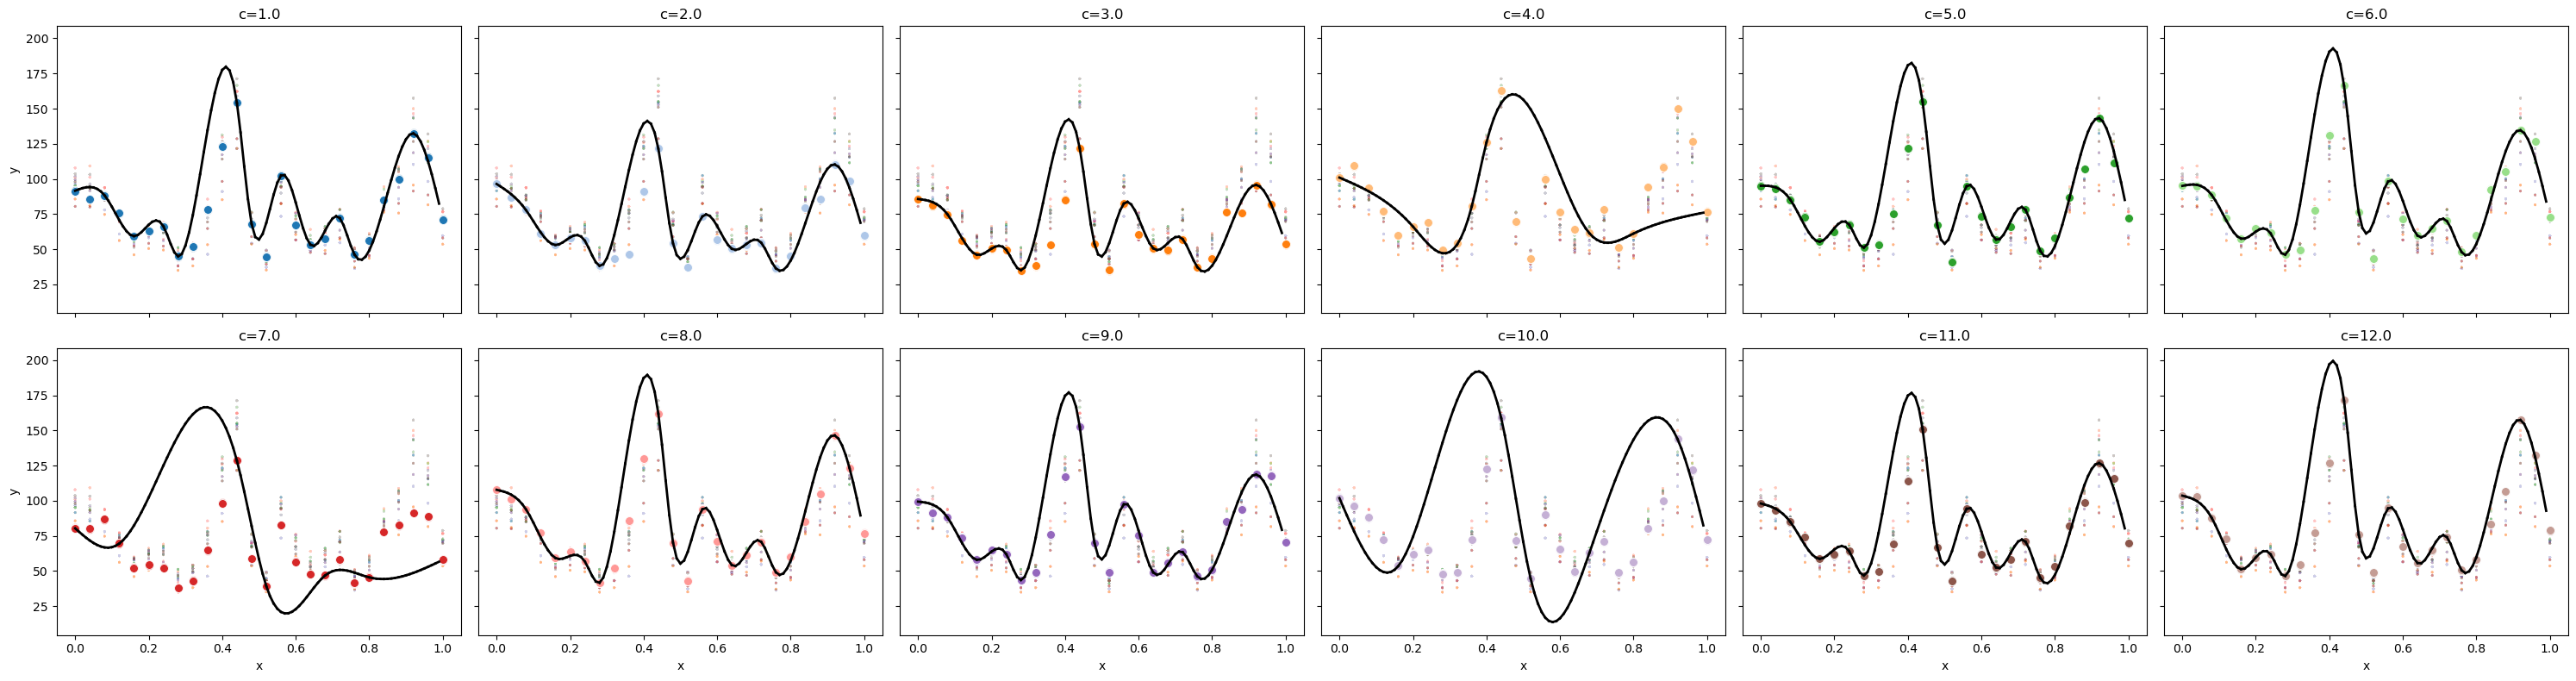

In [24]:
X_test, y_test, t_test, n_classes, timepoints, all_classes = dgp_beijing_data(
    coupling, batch_size, ns_per_t_and_c, dgp=DGP, return_data="test"
)

# Evaluate FSI models on the same TEST data
df_cubic_results_fsi = []
add_time_cond =  [(7, 11)]  #[(i, 0.15) for i in label_list]  # This is the holdout timepoint, FSI is allowed to use
for seed in range(1):
    filename = f"dgp_weather_{DGP}_{seed}_{ns_per_t_and_c}_{train_test_split}"
    if add_time_cond is not None:
        filename = filename + "_" + re.sub(r"[(), ]", "", str(add_time_cond))
    results_path = Path(path_name_fsi) / filename

    df_results_fsi = predict_on_testset_fsi(
        results_path,
        X_test,
        y_test,
        t_test,
        seed=seed,
        coupling=coupling,
        n_classes=len(label_list),
        plot_results=True if seed == 0 else False,
        ncols=6,
    )
    df_cubic_results_fsi.append(df_results_fsi)

df_cubic_results_fsi = pd.concat(df_cubic_results_fsi).reset_index(drop=True)

In [21]:
# Save results to disk
load_results = False
save_results = False

if load_results:
    df_cubic_results_fsi = pd.read_csv("final_df_cubic_results_fsi.csv")

if save_results:
    df_cubic_results_fsi.to_csv("final_df_cubic_results_fsi.csv", index=False)

In [ ]:
assert False

### FM

df, grouping_columns, performance_columns = load_all_models(
    PROD, DGP, load_parquet=True, coupling=coupling, embedding_type=embedding_type, filter_values="_fm"
)
model_type = "fm"

print(f"Data before filtering: {df.shape}")

df = df.loc[
    (df["ns_per_t_and_c"] == ns_per_t_and_c)
    & (df["coupling"] == coupling)
    & (df["data_std"] == data_std)
    & (df["off_diagonal"] == off_diagonal)
    & (df["train_test_split"] == train_test_split)
    & (df["model_type"] == model_type)
]
if not classifier_free:
    df = df.loc[~df["classifier_free"]]

# Filter for validation results
df.loc[:, "train"] = df["train"].astype(bool)
df = df.loc[~df["train"]]

print(f"Data after 1st filtering: {df.shape}")

df, grouping_columns, performance_columns = process_all_fm_models(
    df,
    grouping_columns,
    performance_columns,
    plot=False,
    verbose=False,
    minimum_seeds=5,
    data_cols=[
        "ns_per_t_and_c",
        "coupling",
        "data_std",
        "dgp",
        "interpolation",
        "guidance",
        "embedding_type",
        "classifier_free",
    ],
)

df_cubic = df.loc[(df["interpolation"] == "cubic")]

print(f"Data after 2nd filtering: {df_cubic.shape}")


df_cubic = df_cubic.copy()
df_cubic.loc[:, "weight"] = 1

df_cubic_valid = df_cubic.loc[(df_cubic["time"].isin([0, 1.0]))]
df_cubic_valid.loc[(df_cubic_valid["time"] == 0.15), "weight"] = 10

model_battery, model_guidances, model_states = get_model_battery_of_best_models_wc(
    df_cubic_valid, select_by, n_top_seeds, model_string, DGP, average_out_seed=True, selector="mean"
)

X_test, y_test, t_test, n_classes, timepoints, all_classes = dgp_waves_data(
    coupling, batch_size, dimension, off_diagonal, data_std, ns_per_t_and_c, dgp=DGP, return_data="test"
)

results_fm = Dict()
trajectories_test_fm = Dict()

for seed, model in model_battery.items():
    results = []
    for idx, c in enumerate(label_list):
        trajectories_test_fm[c][seed] = sample_trajectory(
            model,
            X=x_means,
            y=y_test[:, 0],
            device=device,
            guidance=model_guidances[c],
            conditional_model=model_states[seed]["conditional_model"],
            rtol=1e-7,
            atol=1e-9,
            steps=101,
            method="rk4",
        )

        trajectory = np.swapaxes(trajectories_test_fm[c][seed], 0, 1)
        trajectory = trajectory[
            np.arange(trajectory.shape[0])[:, None], (t_test * (trajectory.shape[1] - 1)).astype(int)
        ]

        for marginal in range(trajectory.shape[1]):
            target = X_test[:, marginal][y_test[:, marginal] == c]
            transport = trajectory[:, marginal][y_test[:, 0] == c]
            mmd, mmd_median, wasserstein, mean_diff_l1, mean_diff_l2, kl_div = compute_metric_set(target, transport)

            results.append(
                {
                    "marginal": marginal,
                    "c": c,
                    "mmd": mmd,
                    "mmd_median": mmd_median,
                    "wasserstein": wasserstein,
                    "guidance": model_guidances[c],
                    "train": False,
                    "time": t_test[0, marginal],
                    "mean_diff_l1": mean_diff_l1,
                    "mean_diff_l2": mean_diff_l2,
                    "kl_div": kl_div,
                    "seed": seed,
                }
            )

    results_fm[seed] = pd.DataFrame(results)

df_cubic_results_fm = pd.concat([results_fm[seed] for seed in results_fm], axis=0)
df_cubic_results_fm["model"] = "OT-CFM"

# Save results to disk
load_results = False
save_results = True

if load_results:
    df_cubic_results_fm = pd.read_csv("final_df_cubic_results_fm.csv")

if save_results:
    df_cubic_results_fm.to_csv("final_df_cubic_results_fm.csv", index=False)

### Linear COT-MMFM

In [29]:
df, grouping_columns, performance_columns = load_all_models(
    PROD, DGP, load_parquet=True, coupling=coupling, embedding_type=embedding_type, filter_values="_mmfm"
)
model_type = "mmfm"

Data before filtering: (2920320, 32)
Data after 1st filtering: (2303496, 32)
Data after 2nd filtering: (1033968, 21)


100%|██████████| 1/1 [03:51<00:00, 231.98s/it]


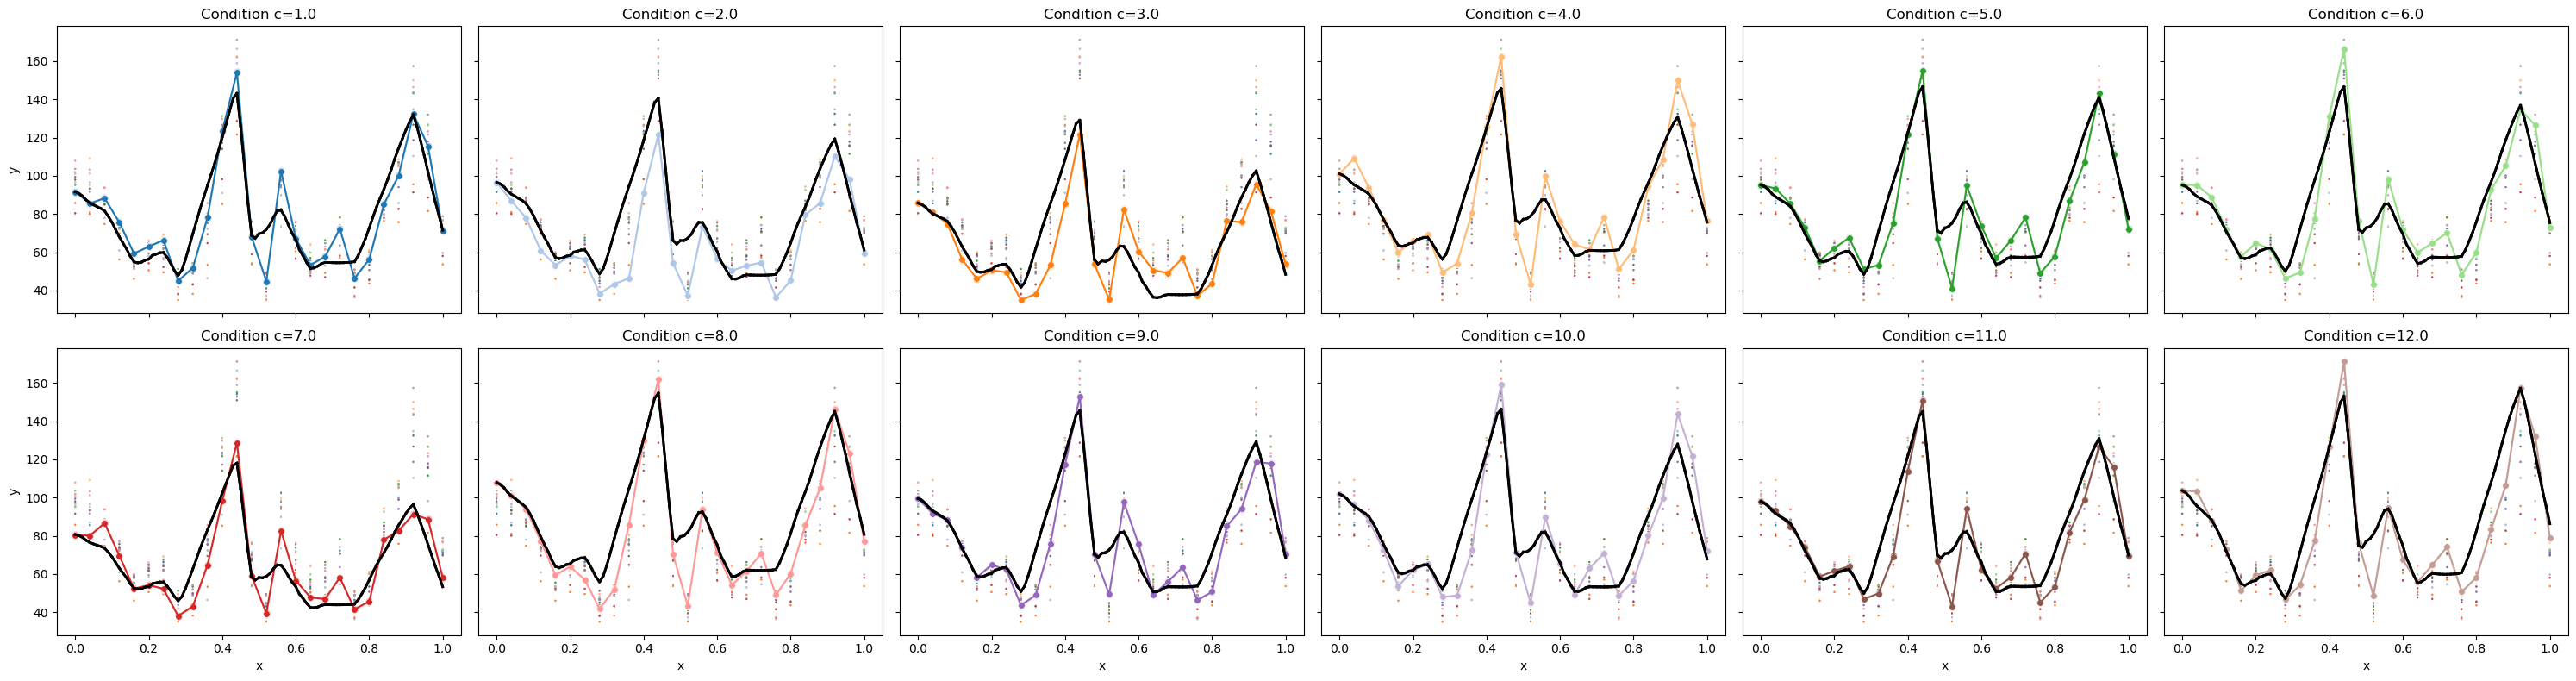

In [30]:
print(f"Data before filtering: {df.shape}")

df = df.loc[
    (df["ns_per_t_and_c"] == ns_per_t_and_c)
    & (df["coupling"] == coupling)
    & (df["train_test_split"] == train_test_split)
    & (df["embedding_type"] == embedding_type)
    & (df["model_type"] == model_type)
    & (df["p_unconditional"] > 0.0)
]
if not classifier_free:
    df = df.loc[~df["classifier_free"]]

# Filter for validation results
df.loc[:, "train"] = df["train"].astype(bool)
df = df.loc[~df["train"]]

print(f"Data after 1st filtering: {df.shape}")

df, grouping_columns, performance_columns = process_all_fm_models(
    df,
    grouping_columns,
    performance_columns,
    plot=False,
    verbose=False,
    minimum_seeds=1,
    data_cols=[
        "ns_per_t_and_c",
        "coupling",
        "dgp",
        "interpolation",
        "guidance",
        "embedding_type",
        "classifier_free",
    ],
)

df_cubic = df.loc[(df["interpolation"] == "linear")]

print(f"Data after 2nd filtering: {df_cubic.shape}")

df_cubic = df_cubic.copy()
df_cubic.loc[:, "weight"] = 1

df_cubic_valid = df_cubic.loc[
    ((df_cubic["c"] == 4) & (df_cubic["time"].isin([0.04 * x for x in [0, 5, 9, 10, 17, 20, 25]])))
    | ((df_cubic["c"] == 7) & (df_cubic["time"].isin([0.04 * x for x in [0, 3, 11, 13, 17, 20, 25]])))
    | ((df_cubic["c"] == 10) & (df_cubic["time"].isin([0.04 * x for x in [0, 4, 11, 13, 17, 23, 25]])))
    | ((df_cubic["c"] != 4) & (df_cubic["c"] != 7) & (df_cubic["c"] != 10) & (df_cubic["time"].isin([0.04 * x for x in [0, 2, 4, 6, 7, 11, 12, 14, 16, 18, 19, 23, 25]])))
]

model_battery, model_guidances, model_states = get_model_battery_of_best_models_wc(
    df_cubic_valid, select_by, n_top_seeds, model_string, DGP, average_out_seed=True, selector="mean"
)

X_test, y_test, t_test, n_classes, timepoints, all_classes = dgp_beijing_data(
    coupling, batch_size, ns_per_t_and_c, dgp=DGP, return_data="test"
)

from tqdm import tqdm

results_mmfm = Dict()
trajectories_test_mmfm = Dict()

for seed, model in tqdm(model_battery.items()):
    results = []
    for idx, c in enumerate(label_list):
        trajectories_test_mmfm[c][seed] = sample_trajectory(
            model,
            X=X_test[:, 0],
            y=y_test[:, 0],
            device=device,
            guidance=model_guidances[c],  # if model_guidances.get(c) else 1,
            conditional_model=model_states[seed]["conditional_model"],
            rtol=1e-7,
            atol=1e-9,
            steps=101,
            method="rk4",
        )

        trajectory = np.swapaxes(trajectories_test_mmfm[c][seed], 0, 1)
        trajectory = trajectory[
            np.arange(trajectory.shape[0])[:, None], (t_test * (trajectory.shape[1] - 1)).astype(int)
        ]

        for marginal in range(trajectory.shape[1]):
            target = X_test[:, marginal][y_test[:, marginal] == c]
            transport = trajectory[:, marginal][y_test[:, 0] == c]
            mmd, mmd_median, wasserstein, mean_diff_l1, mean_diff_l2, kl_div = compute_metric_set(target, transport)

            results.append(
                {
                    "marginal": marginal,
                    "c": c,
                    "mmd": mmd,
                    "mmd_median": mmd_median,
                    "wasserstein": wasserstein,
                    "guidance": model_guidances[c],
                    "train": False,
                    "time": t_test[0, marginal],
                    "mean_diff_l1": mean_diff_l1,
                    "mean_diff_l2": mean_diff_l2,
                    "kl_div": kl_div,
                    "seed": seed,
                }
            )

    results_mmfm[seed] = pd.DataFrame(results)

df_cubic_results_mmfmlin = pd.concat([results_mmfm[seed] for seed in results_mmfm], axis=0)
df_cubic_results_mmfmlin["model"] = "COT-L-MMFM"

for seed in range(1):
    try:
        # Average conditional trajectories for each condition
        trj = {
            c: np.mean([trajectories_test_mmfm[c][seed] for seed in trajectories_test_mmfm[c].keys()], axis=0)
            for c in label_list
        }
        for c in trj.keys():
            trj[c] = {0: trj[c]}

        plot_models_wc(
            trj, 6, 20, coupling, batch_size, ns_per_t_and_c, DGP, 0, save=False, suffix="avg", already_subset=False
        )
    except:
        pass

In [31]:
# Save results to disk
load_results = False
save_results = False

if load_results:
    df_cubic_results_mmfmlin = pd.read_csv("final_df_cubic_results_mmfmlin.csv")

if save_results:
    df_cubic_results_mmfmlin.to_csv("final_df_cubic_results_mmfmlin.csv", index=False)

# TC-OT-CFM

In [ ]:
df, grouping_columns, performance_columns = load_all_models(
    PROD, DGP, load_parquet=False, coupling=coupling, embedding_type=embedding_type, filter_values="_tcotcfm"
)

In [ ]:
model_type = "tcotcfm"

print(f"Data before filtering: {df.shape}")

df = df.loc[
    (df["ns_per_t_and_c"] == ns_per_t_and_c)
    & (df["coupling"] == coupling)
    & (df["data_std"] == data_std)
    & (df["off_diagonal"] == off_diagonal)
    & (df["train_test_split"] == train_test_split)
    & (df["model_type"] == model_type)
]
if not classifier_free:
    df = df.loc[~df["classifier_free"]]

# Filter for validation results
df.loc[:, "train"] = df["train"].astype(bool)
df = df.loc[~df["train"]]

print(f"Data after 1st filtering: {df.shape}")

df, grouping_columns, performance_columns = process_all_fm_models(
    df,
    grouping_columns,
    performance_columns,
    plot=False,
    verbose=True,
    minimum_seeds=5,
    data_cols=[
        "ns_per_t_and_c",
        "coupling",
        "data_std",
        "dgp",
        "interpolation",
        "guidance",
        "embedding_type",
        "classifier_free",
    ],
)

# df_cubic = df.loc[(df["interpolation"] == "linear")]

print(f"Data after 2nd filtering: {df.shape}")

df_cubic = df.copy()
df_cubic.loc[:, "weight"] = 1

df_cubic_valid = df_cubic.loc[
    ((df_cubic["c"] == 3) & (df_cubic["time"].isin([0, 0.1, 0.15, 0.5, 0.9, 1.0])))
    | ((df_cubic["c"] == 5) & (df_cubic["time"].isin([0, 0.15, 0.3, 0.5, 0.7, 1.0])))
    | ((df_cubic["c"] != 3) & (df_cubic["c"] != 5) & (df_cubic["time"].isin([0, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9, 1.0])))
]
df_cubic_valid.loc[(df_cubic_valid["time"] == 0.15), "weight"] = 10
df_cubic_valid.loc[(df_cubic_valid["time"].isin([1])), "weight"] = 5

model_battery, model_guidances, model_states = get_model_battery_of_best_models_wc(
    df_cubic_valid, select_by, n_top_seeds, model_string, DGP, average_out_seed=True, selector="mean", model="tcotcfm"
)

X_test, y_test, t_test, n_classes, timepoints, all_classes = dgp_waves_data(
    coupling, batch_size, dimension, off_diagonal, data_std, ns_per_t_and_c, dgp=DGP, return_data="test"
)

results_tcotcfm = Dict()
trajectories_test_tcotcfm = Dict()

for seed, model in model_battery.items():
    results = []
    for idx, c in enumerate(label_list):
        trajectories_test_tcotcfm[c][seed] = sample_trajectory(
            model,
            X=x_means[y_test[:, 0] == c, :],
            y=y_test[y_test[:, 0] == c, 0],
            device=device,
            guidance=model_guidances[c],
            conditional_model=model_states[seed]["conditional_model"],
            rtol=1e-7,
            atol=1e-9,
            steps=101,
            method="rk4",
        )

        trajectory = np.swapaxes(trajectories_test_tcotcfm[c][seed], 0, 1)
        trajectory = trajectory[
            np.arange(trajectory.shape[0])[:, None],
            (t_test[y_test[:, 0] == c, :] * (trajectory.shape[1] - 1)).astype(int),
        ]

        for marginal in range(trajectory.shape[1]):
            target = X_test[:, marginal][y_test[:, marginal] == c]
            transport = trajectory[:, marginal]  # [y_test[:, 0] == c]
            mmd, mmd_median, wasserstein, mean_diff_l1, mean_diff_l2, kl_div = compute_metric_set(
                target, transport, kl_div_skip=True
            )

            results.append(
                {
                    "marginal": marginal,
                    "c": c,
                    "mmd": mmd,
                    "mmd_median": mmd_median,
                    "wasserstein": wasserstein,
                    "guidance": model_guidances[c],
                    "train": False,
                    "time": t_test[0, marginal],
                    "mean_diff_l1": mean_diff_l1,
                    "mean_diff_l2": mean_diff_l2,
                    "kl_div": kl_div,
                    "seed": seed,
                }
            )

    results_tcotcfm[seed] = pd.DataFrame(results)

df_cubic_results_tcotcfm = pd.concat([results_tcotcfm[seed] for seed in results_tcotcfm], axis=0)
df_cubic_results_tcotcfm["model"] = "TC-OT-CFM"

In [ ]:
for seed in range(1):
    plot_models_wc(
        trajectories_test_tcotcfm,
        6,
        20,
        coupling,
        batch_size,
        dimension,
        off_diagonal,
        data_std,
        ns_per_t_and_c,
        DGP,
        seed,
        save=True,
        suffix="TC-OT-CFM",
        already_subset=True
    )

In [ ]:
# Save results to disk
load_results = False
save_results = True

if load_results:
    df_cubic_results_tcotcfm = pd.read_csv("final_df_cubic_results_tcotcfm.csv")

if save_results:
    df_cubic_results_tcotcfm.to_csv("final_df_cubic_results_tcotcfm.csv", index=False)

### T-OT-CFM

In [ ]:
df, grouping_columns, performance_columns = load_all_models(
    PROD, DGP, load_parquet=False, coupling=coupling, embedding_type=embedding_type, filter_values="totcfm"
)
print(f"Data before filtering: {df.shape}")

In [ ]:
model_type = "totcfm"

df = df.loc[
    (df["ns_per_t_and_c"] == ns_per_t_and_c)
    & (df["coupling"] == coupling)
    & (df["data_std"] == data_std)
    & (df["off_diagonal"] == off_diagonal)
    & (df["train_test_split"] == train_test_split)
    & (df["model_type"] == model_type)
]
if not classifier_free:
    df = df.loc[~df["classifier_free"]]

# Filter for validation results
df.loc[:, "train"] = df["train"].astype(bool)
df = df.loc[~df["train"]]

print(f"Data after 1st filtering: {df.shape}")

df, grouping_columns, performance_columns = process_all_fm_models(
    df,
    grouping_columns,
    performance_columns,
    plot=False,
    verbose=True,
    minimum_seeds=5,
    data_cols=[
        "ns_per_t_and_c",
        "coupling",
        "data_std",
        "dgp",
        "interpolation",
        "guidance",
        "embedding_type",
        "classifier_free",
    ],
)

print(f"Data after 2nd filtering: {df.shape}")

df_cubic = df.copy()
df_cubic.loc[:, "weight"] = 1

df_cubic_valid = df_cubic.loc[
    ((df_cubic["c"] == 3) & (df_cubic["time"].isin([0, 0.1, 0.15, 0.5, 0.9, 1.0])))
    | ((df_cubic["c"] == 5) & (df_cubic["time"].isin([0, 0.15, 0.3, 0.5, 0.7, 1.0])))
    | ((df_cubic["c"] != 3) & (df_cubic["c"] != 5) & (df_cubic["time"].isin([0, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9, 1.0])))
]
df_cubic_valid.loc[(df_cubic_valid["time"] == 0.15), "weight"] = 10
df_cubic_valid.loc[(df_cubic_valid["time"].isin([1])), "weight"] = 5

model_battery, model_guidances, model_states = get_model_battery_of_best_models_wc(
    df_cubic_valid, select_by, n_top_seeds, model_string, DGP, average_out_seed=True, selector="mean", model="totcfm"
)

X_test, y_test, t_test, n_classes, timepoints, all_classes = dgp_waves_data(
    coupling, batch_size, dimension, off_diagonal, data_std, ns_per_t_and_c, dgp=DGP, return_data="test"
)

results_totcfm = Dict()
trajectories_test_totcfm = Dict()

In [ ]:
for seed, model in model_battery.items():
    results = []
    for idx, c in enumerate(label_list):
        trajectories_test_totcfm[c][seed] = sample_trajectory(
            model,
            X=x_means[y_test[:, 0] == c, :],
            y=y_test[y_test[:, 0] == c, 0],
            device=device,
            guidance=model_guidances[c],
            conditional_model=model_states[seed]["conditional_model"],
            rtol=1e-7,
            atol=1e-9,
            steps=101,
            method="rk4",
        )

        trajectory = np.swapaxes(trajectories_test_totcfm[c][seed], 0, 1)
        trajectory = trajectory[
            np.arange(trajectory.shape[0])[:, None],
            (t_test[y_test[:, 0] == c, :] * (trajectory.shape[1] - 1)).astype(int),
        ]

        for marginal in range(trajectory.shape[1]):
            target = X_test[:, marginal][y_test[:, marginal] == c]
            transport = trajectory[:, marginal]  # [y_test[:, 0] == c]
            mmd, mmd_median, wasserstein, mean_diff_l1, mean_diff_l2, kl_div = compute_metric_set(
                target, transport, kl_div_skip=True
            )

            results.append(
                {
                    "marginal": marginal,
                    "c": c,
                    "mmd": mmd,
                    "mmd_median": mmd_median,
                    "wasserstein": wasserstein,
                    "guidance": model_guidances[c],
                    "train": False,
                    "time": t_test[0, marginal],
                    "mean_diff_l1": mean_diff_l1,
                    "mean_diff_l2": mean_diff_l2,
                    "kl_div": kl_div,
                    "seed": seed,
                }
            )

    results_totcfm[seed] = pd.DataFrame(results)

df_cubic_results_totcfm = pd.concat([results_totcfm[seed] for seed in results_totcfm], axis=0)
df_cubic_results_totcfm["model"] = "T-OT-CFM"

In [ ]:
for seed in range(1):
    plot_models_wc(
        trajectories_test_totcfm,
        6,
        20,
        coupling,
        batch_size,
        dimension,
        off_diagonal,
        data_std,
        ns_per_t_and_c,
        DGP,
        seed,
        save=True,
        suffix="T-OT-CFM",
        already_subset=True
    )

In [ ]:
# Save results to disk
load_results = False
save_results = True

if load_results:
    df_cubic_results_totcfm = pd.read_csv("final_df_cubic_results_totcfm.csv")

if save_results:
    df_cubic_results_totcfm.to_csv("final_df_cubic_results_totcfm.csv", index=False)

In [32]:
df_results = pd.concat(
    [
        # df_cubic_results_fm,
        df_cubic_results_fsi,
        df_cubic_results_mmfmlin,
        df_cubic_results_mmfm,
        # df_cubic_results_tcotcfm,
        # df_cubic_results_totcfm,
    ],
    ignore_index=True,
    axis=0,
).reset_index(drop=True)

In [ ]:
df_results.loc[:, "training"] = False

for model_name in ["COT-MMFM", "L-COT-MMFM", "T-OT-CFM", "L-COT-MMFM", "TC-OT-CFM"]:
    df_results.loc[
        (df_results["c"] == 3)
        & (df_results["model"] == model_name)
        & (df_results["time"].isin([0, 0.1, 0.5, 0.9, 1.0])),
        "training",
    ] = True
    df_results.loc[
        (df_results["c"] == 5)
        & (df_results["model"] == model_name)
        & (df_results["time"].isin([0, 0.3, 0.5, 0.7, 1.0])),
        "training",
    ] = True
    df_results.loc[
        (df_results["c"] != 3)
        & (df_results["c"] != 5)
        & (df_results["model"] == model_name)
        & (df_results["time"].isin([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])),
        "training",
    ] = True

df_results.loc[
    (df_results["model"] == "OT-CFM") & (df_results["time"].isin([0, 1.0])),
    "training",
] = True

df_results.loc[
    (df_results["c"] == 3)
    & (df_results["model"] == "COT-FSI")
    & (df_results["time"].isin([0, 0.1, 0.15, 0.5, 0.9, 1.0])),
    "training",
] = True
df_results.loc[
    (df_results["c"] == 5)
    & (df_results["model"] == "COT-FSI")
    & (df_results["time"].isin([0, 0.15, 0.3, 0.5, 0.7, 1.0])),
    "training",
] = True
df_results.loc[
    (df_results["c"] != 3)
    & (df_results["c"] != 5)
    & (df_results["model"] == "COT-FSI")
    & (df_results["time"].isin([0, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9, 1.0])),
    "training",
] = True

In [ ]:
df_r = (
    df_results.groupby(["model"])
    .agg(
        {
            "mmd": ["mean", "std", "max"],
            "mmd_median": ["mean", "std", "max"],
            "wasserstein": ["mean", "std", "max"],
            "mean_diff_l1": ["mean", "std", "max"],
            "mean_diff_l2": ["mean", "std", "max"],
        }
    )
    .round(2)
    .rename(columns={"model": "Model"})[["mean_diff_l2", "wasserstein"]]
    .reset_index()
)
df_r

In [ ]:
df_results["condition_value"] = df_results["c"].apply(lambda x: "3" if x == 3 else ("5" if x == 5 else "R"))

df_r = (
    df_results.groupby(["model", "training", "condition_value"])
    .agg(
        {
            "mmd": ["mean", "std", "max"],
            "mmd_median": ["mean", "std", "max"],
            "wasserstein": ["mean", "std", "max"],
            "mean_diff_l1": ["mean", "std", "max"],
            "mean_diff_l2": ["mean", "std", "max"],
        }
    )
    .round(2)
    .rename(columns={"model": "Model"})[["mean_diff_l1", "mean_diff_l2", "wasserstein", "mmd", "mmd_median"]]
    .reset_index()
)
df_r = df_r.loc[~df_r["training"]]
df_r.sort_values(["condition_value"]).reset_index(drop=True)